---
we'll use tensorflow to predict the number of shapes in each image.

first let's get the pixel data, saving it as `.npy` files in `greyscale-data`

---

In [1]:
import os
import numpy as np
import png


input_directory = 'greyscale-images'
output_directory = 'greyscale-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  path = os.path.join(input_directory, filename)
  with open(path, 'rb') as image_file:
    reader = png.Reader(file=image_file)
    _, _, pixels, _ = reader.asDirect()
    data = np.array([x / 255. for row in pixels for x in row])
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, data)

---
load data into various structures for later

---

In [2]:
input_directory = 'greyscale-data'

# Load all the data into an array.
# Each element is a tuple: (filename, numpy data).
# The filename structure is "<number>-<color>-<texture>-<shape>-<rotation>.png"
all_data = [
  (f, np.load(os.path.join(input_directory, f))) for f in os.listdir(input_directory)
]

# Grab all the input data into a separate array.
all_input_pixel_data = [pixel_data for _, pixel_data in all_data]

# Each filename, in its text, has an embedded "number of shapes."
# We need to convert those classes (the output ground truth) into a category array.
possible_categories = [
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.],
]
all_output_categories = [
  possible_categories[int(filename.split('-')[0]) - 1] for filename, _ in all_data
]

---
exactly how many input datapoints do we have again?

---

In [32]:
print len(all_input_pixel_data)

648


---
setup tensorflow

---

In [29]:
import random
import tensorflow as tf


learning_rate = 1e-6
card_width, card_height = 150, 150

input_pixel_data = tf.placeholder(tf.float32, shape=[None, card_width*card_height])
weights = tf.Variable(tf.zeros([card_width*card_height, 3]))
biases = tf.Variable(tf.zeros([3]))
estimated_output_category = tf.nn.softmax(tf.matmul(input_pixel_data, weights) + biases)
actual_output_category = tf.placeholder(tf.float32, [None, 3])

cross_entropy = -tf.reduce_sum(actual_output_category * tf.log(estimated_output_category))
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(
  tf.argmax(estimated_output_category, 1), 
  tf.argmax(actual_output_category, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

---
and run the optimizer in batches

---

In [30]:
measured_iterations, measured_accuracies = [], []
total_iterations = 1000
batch_size = 100

session = tf.Session()
session.run(tf.initialize_all_variables())

for iteration in range(total_iterations):
  batch_data = random.sample(all_data, batch_size)
  batch_input_pixel_data = [pixel_data for _, pixel_data in batch_data]
  batch_output_categories = [
    possible_categories[int(filename.split('-')[0]) - 1] for filename, _ in batch_data
  ]
  training_data = {
    input_pixel_data: batch_input_pixel_data,
    actual_output_category: batch_output_categories,
  }
  
  session.run(train_step, feed_dict=training_data)
  
  if (iteration % 50) == 0:
    accuracy_measurement_data = {
      input_pixel_data: all_input_pixel_data,
      actual_output_category: all_output_categories,
    }
    measured_accuracy = session.run(accuracy, feed_dict=accuracy_measurement_data)
    measured_iterations.append(iteration)
    measured_accuracies.append(measured_accuracy)
    if (iteration % 100) == 0:
      print 'iteration: %s -> accuracy: %s' % (iteration, measured_accuracy)

print 'done.'

iteration: 0 -> accuracy: 0.351852
iteration: 100 -> accuracy: 0.490741
iteration: 200 -> accuracy: 0.712963
iteration: 300 -> accuracy: 0.908951
iteration: 400 -> accuracy: 0.962963
iteration: 500 -> accuracy: 0.987654
iteration: 600 -> accuracy: 0.975309
iteration: 700 -> accuracy: 0.932099
iteration: 800 -> accuracy: 1.0
iteration: 900 -> accuracy: 1.0
done.


---
plot the accuracy vs iteration number

---

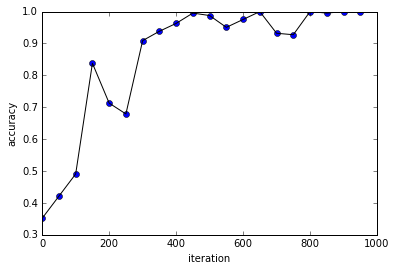

In [31]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(measured_iterations, measured_accuracies, 'bo')
plt.plot(measured_iterations, measured_accuracies, 'k-')
_ = plt.xlabel('iteration')
_ = plt.ylabel('accuracy')